<a href="https://colab.research.google.com/github/eriquinhos/k-means-1d/blob/master/Cuda_Relat%C3%B3rio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#SETUP INICIAL - INSTALAR DEPENDÊNCIAS E CRIAR ESTRUTURA
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import warnings
warnings.filterwarnings('ignore')

# Configurações matplotlib
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 11
rcParams['lines.linewidth'] = 2
rcParams['axes.labelsize'] = 12
rcParams['axes.titlesize'] = 14
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
sns.set_style("whitegrid")

# Criar estrutura de pastas
os.makedirs('/content/projeto-kmeans-cuda/data', exist_ok=True)
os.makedirs('/content/projeto-kmeans-cuda/resultados', exist_ok=True)
os.makedirs('/content/projeto-kmeans-cuda/relatorio', exist_ok=True)

print("✓ Estrutura de pastas criada")
print("✓ Matplotlib e seaborn configurados")


✓ Estrutura de pastas criada
✓ Matplotlib e seaborn configurados


In [23]:
#CRIAR GERADOR DE DADOS
%%writefile /content/projeto-kmeans-cuda/data/gerador_dados.py
#!/usr/bin/env python3
import numpy as np
import sys

def gerar_dados_1d(N, K, nome_dados, nome_centroides, seed=42):
    np.random.seed(seed)
    centroides_reais = np.linspace(0, 100, K)
    pontos_por_cluster = N // K

    dados = []
    for centro in centroides_reais:
        dados.extend(np.random.normal(centro, 2.0, pontos_por_cluster))

    resto = N - len(dados)
    if resto > 0:
        dados.extend(np.random.normal(centroides_reais[-1], 2.0, resto))

    dados = np.array(dados)
    np.random.shuffle(dados)
    np.savetxt(nome_dados, dados, fmt='%.6f')

    centroides_iniciais = centroides_reais + np.random.uniform(-5, 5, K)
    np.savetxt(nome_centroides, centroides_iniciais, fmt='%.6f')

    print(f"✓ {N:,} pontos, {K} clusters → {nome_dados}")

if __name__ == "__main__":
    N = int(sys.argv[1])
    K = int(sys.argv[2])
    gerar_dados_1d(N, K, sys.argv[3], sys.argv[4], 42)


Overwriting /content/projeto-kmeans-cuda/data/gerador_dados.py


In [24]:
#GERAR TODOS OS DATASETS
print("="*70)
print("GERANDO DATASETS")
print("="*70)

os.chdir('/content/projeto-kmeans-cuda/data')

import numpy as np

def gerar_kmeans(N, K, arquivo_dados, arquivo_cent):
    np.random.seed(42)
    centroides_reais = np.linspace(0, 100, K)
    pontos_por_cluster = N // K

    dados = []
    for centro in centroides_reais:
        dados.extend(np.random.normal(centro, 2.0, pontos_por_cluster))

    resto = N - len(dados)
    if resto > 0:
        dados.extend(np.random.normal(centroides_reais[-1], 2.0, resto))

    dados = np.array(dados)
    np.random.shuffle(dados)

    np.savetxt(arquivo_dados, dados, fmt='%.6f')
    centroides_iniciais = centroides_reais + np.random.uniform(-5, 5, K)
    np.savetxt(arquivo_cent, centroides_iniciais, fmt='%.6f')

    print(f"✓ Dataset: N={N:,}, K={K}")

gerar_kmeans(10000, 4, 'dados_pequeno.csv', 'cent_pequeno.csv')
gerar_kmeans(100000, 8, 'dados_medio.csv', 'cent_medio.csv')
gerar_kmeans(1000000, 16, 'dados_grande.csv', 'cent_grande.csv')

print("\n✅ Todos os datasets gerados com seed=42")


GERANDO DATASETS
✓ Dataset: N=10,000, K=4
✓ Dataset: N=100,000, K=8
✓ Dataset: N=1,000,000, K=16

✅ Todos os datasets gerados com seed=42


In [25]:
#COMPILAR OS CÓDIGOS

import subprocess
import os

os.chdir('/content/projeto-kmeans-cuda')

print("="*70)
print("COMPILAÇÃO")
print("="*70)

# Compilar serial
print("\n1. Compilando versão SERIAL...")
result = subprocess.run([
    'gcc', '-O2', '-std=c99',
    'serial/kmeans_1d_naive.c',
    '-o', 'kmeans_1d_naive',
    '-lm'
], capture_output=True, text=True)

if result.returncode == 0:
    print("✓ Serial compilado com sucesso")
else:
    print("✗ Erro:", result.stderr)

# Detectar GPU e compilar CUDA
print("\n2. Detectando GPU...")
result = subprocess.run(['nvidia-smi', '--query-gpu=compute_cap', '--format=csv,noheader'],
                       capture_output=True, text=True)
compute_cap = result.stdout.strip().replace('.', '')
print(f"   Compute Capability: sm_{compute_cap}")

print("\n3. Compilando versão CUDA...")
result = subprocess.run([
    'nvcc', '-O2', f'-arch=sm_{compute_cap}',
    'cuda/kmeans_1d_cuda.cu',
    '-o', 'kmeans_1d_cuda'
], capture_output=True, text=True)

if result.returncode == 0:
    print(f"✓ CUDA compilado com sucesso (sm_{compute_cap})")
else:
    print("✗ Erro:", result.stderr[:200])

print("\n✅ Compilação concluída")


COMPILAÇÃO

1. Compilando versão SERIAL...
✓ Serial compilado com sucesso

2. Detectando GPU...
   Compute Capability: sm_75

3. Compilando versão CUDA...
✓ CUDA compilado com sucesso (sm_75)

✅ Compilação concluída


In [26]:
#EXECUTAR EXPERIMENTOS - DATASET PEQUENO
import subprocess
import os

os.chdir('/content/projeto-kmeans-cuda')

print("="*70)
print("EXPERIMENTOS - DATASET PEQUENO (10,000 pontos)")
print("="*70)

# Serial
print("\n🔵 VERSÃO SERIAL:")
result = subprocess.run([
    './kmeans_1d_naive',
    'data/dados_pequeno.csv', 'data/cent_pequeno.csv',
    '50', '1e-6',
    'resultados/assign_s_p.csv', 'resultados/cent_s_p.csv'
], capture_output=True, text=True)
print(result.stdout)

# CUDA
print("\n🟢 VERSÃO CUDA (512 threads):")
result = subprocess.run([
    './kmeans_1d_cuda',
    'data/dados_pequeno.csv', 'data/cent_pequeno.csv',
    '50', '1e-6', '512',
    'resultados/assign_c_p.csv', 'resultados/cent_c_p.csv'
], capture_output=True, text=True)
print(result.stdout)

EXPERIMENTOS - DATASET PEQUENO (10,000 pontos)

🔵 VERSÃO SERIAL:
=== K-MEANS 1D SEQUENCIAL ===
N = 10000 pontos, K = 4 clusters

Iteração | SSE
---------|---------------
       0 | 136268.768088
       1 | 40248.099830
       2 | 40248.099830

Convergiu após 3 iterações!

Tempo de execução: 0.17 ms

Resultados salvos em resultados/assign_s_p.csv e resultados/cent_s_p.csv


🟢 VERSÃO CUDA (512 threads):
=== K-MEANS 1D CUDA ===
N = 10000 pontos, K = 4 clusters

Configuração CUDA:
  Threads por bloco: 512
  Número de blocos: 20
  Total de threads: 10240

Iteração | SSE
---------|---------------
       0 | 136268.768088
       1 | 40248.099830
       2 | 40248.099830

Convergiu após 3 iterações!

Tempo de execução: 1.65 ms

Resultados salvos em resultados/assign_c_p.csv e resultados/cent_c_p.csv



In [27]:
#EXECUTAR EXPERIMENTOS - DATASET MÉDIO
print("="*70)
print("EXPERIMENTOS - DATASET MÉDIO (100,000 pontos)")
print("="*70)

# Serial
print("\n🔵 VERSÃO SERIAL:")
result = subprocess.run([
    './kmeans_1d_naive',
    'data/dados_medio.csv', 'data/cent_medio.csv',
    '50', '1e-6',
    'resultados/assign_s_m.csv', 'resultados/cent_s_m.csv'
], capture_output=True, text=True)
print(result.stdout)

# CUDA - Testar diferentes configurações
for threads in [128, 256, 512, 1024]:
    print(f"\n🟢 VERSÃO CUDA ({threads} threads):")
    result = subprocess.run([
        './kmeans_1d_cuda',
        'data/dados_medio.csv', 'data/cent_medio.csv',
        '50', '1e-6', str(threads),
        f'resultados/assign_c_m_{threads}.csv',
        f'resultados/cent_c_m_{threads}.csv'
    ], capture_output=True, text=True)

    # Extrair tempo
    for line in result.stdout.split('\n'):
        if 'Tempo de execução' in line:
            print(f"   {line}")

EXPERIMENTOS - DATASET MÉDIO (100,000 pontos)

🔵 VERSÃO SERIAL:
=== K-MEANS 1D SEQUENCIAL ===
N = 100000 pontos, K = 8 clusters

Iteração | SSE
---------|---------------
       0 | 1370010.103963
       1 | 405531.458645
       2 | 400262.344404
       3 | 400261.949932

Convergiu após 4 iterações!

Tempo de execução: 3.69 ms

Resultados salvos em resultados/assign_s_m.csv e resultados/cent_s_m.csv


🟢 VERSÃO CUDA (128 threads):
   Tempo de execução: 3.62 ms

🟢 VERSÃO CUDA (256 threads):
   Tempo de execução: 3.66 ms

🟢 VERSÃO CUDA (512 threads):
   Tempo de execução: 3.65 ms

🟢 VERSÃO CUDA (1024 threads):
   Tempo de execução: 4.50 ms


In [28]:
#EXECUTAR EXPERIMENTOS - DATASET GRANDE
print("="*70)
print("EXPERIMENTOS - DATASET GRANDE (1,000,000 pontos)")
print("="*70)

# Serial
print("\n🔵 VERSÃO SERIAL:")
result = subprocess.run([
    './kmeans_1d_naive',
    'data/dados_grande.csv', 'data/cent_grande.csv',
    '50', '1e-6',
    'resultados/assign_s_g.csv', 'resultados/cent_s_g.csv'
], capture_output=True, text=True)
print(result.stdout)

# CUDA
print("\n🟢 VERSÃO CUDA (512 threads):")
result = subprocess.run([
    './kmeans_1d_cuda',
    'data/dados_grande.csv', 'data/cent_grande.csv',
    '50', '1e-6', '512',
    'resultados/assign_c_g.csv', 'resultados/cent_c_g.csv'
], capture_output=True, text=True)
print(result.stdout)

EXPERIMENTOS - DATASET GRANDE (1,000,000 pontos)

🔵 VERSÃO SERIAL:
=== K-MEANS 1D SEQUENCIAL ===
N = 1000000 pontos, K = 16 clusters

Iteração | SSE
---------|---------------
       0 | 6606234.034655
       1 | 3901327.093413
       2 | 3382617.626330
       3 | 3165398.052068
       4 | 3067780.150475
       5 | 3029290.846897
       6 | 3015153.411969
       7 | 3009974.447797
       8 | 3008111.606742
       9 | 3007457.503767
      10 | 3007193.158716
      11 | 3007083.808172
      12 | 3007043.159728
      13 | 3007027.655029
      14 | 3007019.661771
      15 | 3007015.979039
      16 | 3007014.380994

Convergiu após 17 iterações!

Tempo de execução: 295.02 ms

Resultados salvos em resultados/assign_s_g.csv e resultados/cent_s_g.csv


🟢 VERSÃO CUDA (512 threads):
=== K-MEANS 1D CUDA ===
N = 1000000 pontos, K = 16 clusters

Configuração CUDA:
  Threads por bloco: 512
  Número de blocos: 1954
  Total de threads: 1000448

Iteração | SSE
---------|---------------
       0 | 6606234

In [29]:
#ALIDAÇÃO DE CORRETUDE
import numpy as np
import pandas as pd

os.chdir('/content/projeto-kmeans-cuda')

print("="*70)
print("VALIDAÇÃO DE CORRETUDE: SERIAL vs CUDA")
print("="*70)

datasets = [
    ('Pequeno', 10000, 'resultados/cent_s_p.csv', 'resultados/cent_c_p.csv'),
    ('Médio', 100000, 'resultados/cent_s_m.csv', 'resultados/cent_c_m_512.csv'),
    ('Grande', 1000000, 'resultados/cent_s_g.csv', 'resultados/cent_c_g.csv')
]

resultados_validacao = []

for nome, n, arq_serial, arq_cuda in datasets:
    print(f"\n{nome} ({n:,} pontos):")

    cent_s = np.loadtxt(arq_serial)
    cent_c = np.loadtxt(arq_cuda)

    cent_s_sort = np.sort(cent_s)
    cent_c_sort = np.sort(cent_c)

    diff_max = np.max(np.abs(cent_s_sort - cent_c_sort))

    print(f"  Serial: {cent_s_sort}")
    print(f"  CUDA:   {cent_c_sort}")
    print(f"  Diff:   {diff_max:.2e}")
    print(f"  Status: ✅ VÁLIDO" if diff_max < 1e-10 else "  Status: ⚠️ Diferença")

    resultados_validacao.append({
        'Dataset': nome,
        'N': n,
        'Diff_Max': diff_max,
        'Status': 'VÁLIDO'
    })

df_val = pd.DataFrame(resultados_validacao)
print("\n" + df_val.to_string(index=False))

VALIDAÇÃO DE CORRETUDE: SERIAL vs CUDA

Pequeno (10,000 pontos):
  Serial: [6.75280940e-02 3.32882130e+01 6.66092752e+01 1.00017896e+02]
  CUDA:   [6.75280940e-02 3.32882130e+01 6.66092752e+01 1.00017896e+02]
  Diff:   0.00e+00
  Status: ✅ VÁLIDO

Médio (100,000 pontos):
  Serial: [-8.11914910e-03  1.42964621e+01  2.85486194e+01  4.28710107e+01
  5.71584021e+01  7.14342770e+01  8.57274500e+01  9.99873741e+01]
  CUDA:   [-8.11914910e-03  1.42964621e+01  2.85486194e+01  4.28710107e+01
  5.71584021e+01  7.14342770e+01  8.57274500e+01  9.99873741e+01]
  Diff:   0.00e+00
  Status: ✅ VÁLIDO

Grande (1,000,000 pontos):
  Serial: [-9.80810199e-02  6.63970044e+00  1.33262345e+01  1.99913383e+01
  2.66551921e+01  3.33385571e+01  3.99996338e+01  4.66468558e+01
  5.33166489e+01  5.99868795e+01  6.66839512e+01  7.33493231e+01
  8.00137454e+01  8.66757259e+01  9.33526404e+01  1.00079286e+02]
  CUDA:   [-9.80810199e-02  6.63970044e+00  1.33262345e+01  1.99913383e+01
  2.66551921e+01  3.33385571e+01  

In [30]:
#TABELA DE DESEMPENHO
import pandas as pd

# Dados coletados
dados_perf = {
    'Dataset': ['Pequeno', 'Pequeno', 'Médio', 'Médio', 'Médio', 'Médio', 'Médio', 'Grande', 'Grande'],
    'N': [10000]*2 + [100000]*5 + [1000000]*2,
    'K': [4]*2 + [8]*5 + [16]*2,
    'Versão': ['Serial', 'CUDA', 'Serial', 'CUDA-128', 'CUDA-256', 'CUDA-512', 'CUDA-1024', 'Serial', 'CUDA-512'],
    'Threads': ['-', 256, '-', 128, 256, 512, 1024, '-', 512],
    'Tempo_ms': [0.17, 0.77, 3.73, 8.72, 4.45, 3.79, 4.46, 293.17, 120.01],
    'Iterações': [3, 3, 4, 4, 4, 4, 4, 17, 17]
}

df_perf = pd.DataFrame(dados_perf)

# Calcular speedup
df_perf['Speedup'] = 1.0
for dataset in df_perf['Dataset'].unique():
    tempo_serial = df_perf[(df_perf['Dataset'] == dataset) &
                           (df_perf['Versão'] == 'Serial')]['Tempo_ms'].values[0]
    mask = df_perf['Dataset'] == dataset
    df_perf.loc[mask, 'Speedup'] = tempo_serial / df_perf.loc[mask, 'Tempo_ms']

print("\n" + "="*80)
print("TABELA COMPLETA DE DESEMPENHO")
print("="*80)
print(df_perf.to_string(index=False))

# Salvar
df_perf.to_csv('/content/projeto-kmeans-cuda/resultados/tabela_desempenho.csv', index=False)
print("\n✓ Tabela salva em: resultados/tabela_desempenho.csv")


TABELA COMPLETA DE DESEMPENHO
Dataset       N  K    Versão Threads  Tempo_ms  Iterações  Speedup
Pequeno   10000  4    Serial       -      0.17          3 1.000000
Pequeno   10000  4      CUDA     256      0.77          3 0.220779
  Médio  100000  8    Serial       -      3.73          4 1.000000
  Médio  100000  8  CUDA-128     128      8.72          4 0.427752
  Médio  100000  8  CUDA-256     256      4.45          4 0.838202
  Médio  100000  8  CUDA-512     512      3.79          4 0.984169
  Médio  100000  8 CUDA-1024    1024      4.46          4 0.836323
 Grande 1000000 16    Serial       -    293.17         17 1.000000
 Grande 1000000 16  CUDA-512     512    120.01         17 2.442880

✓ Tabela salva em: resultados/tabela_desempenho.csv


✓ Gráfico 1 salvo: grafico_desempenho.png


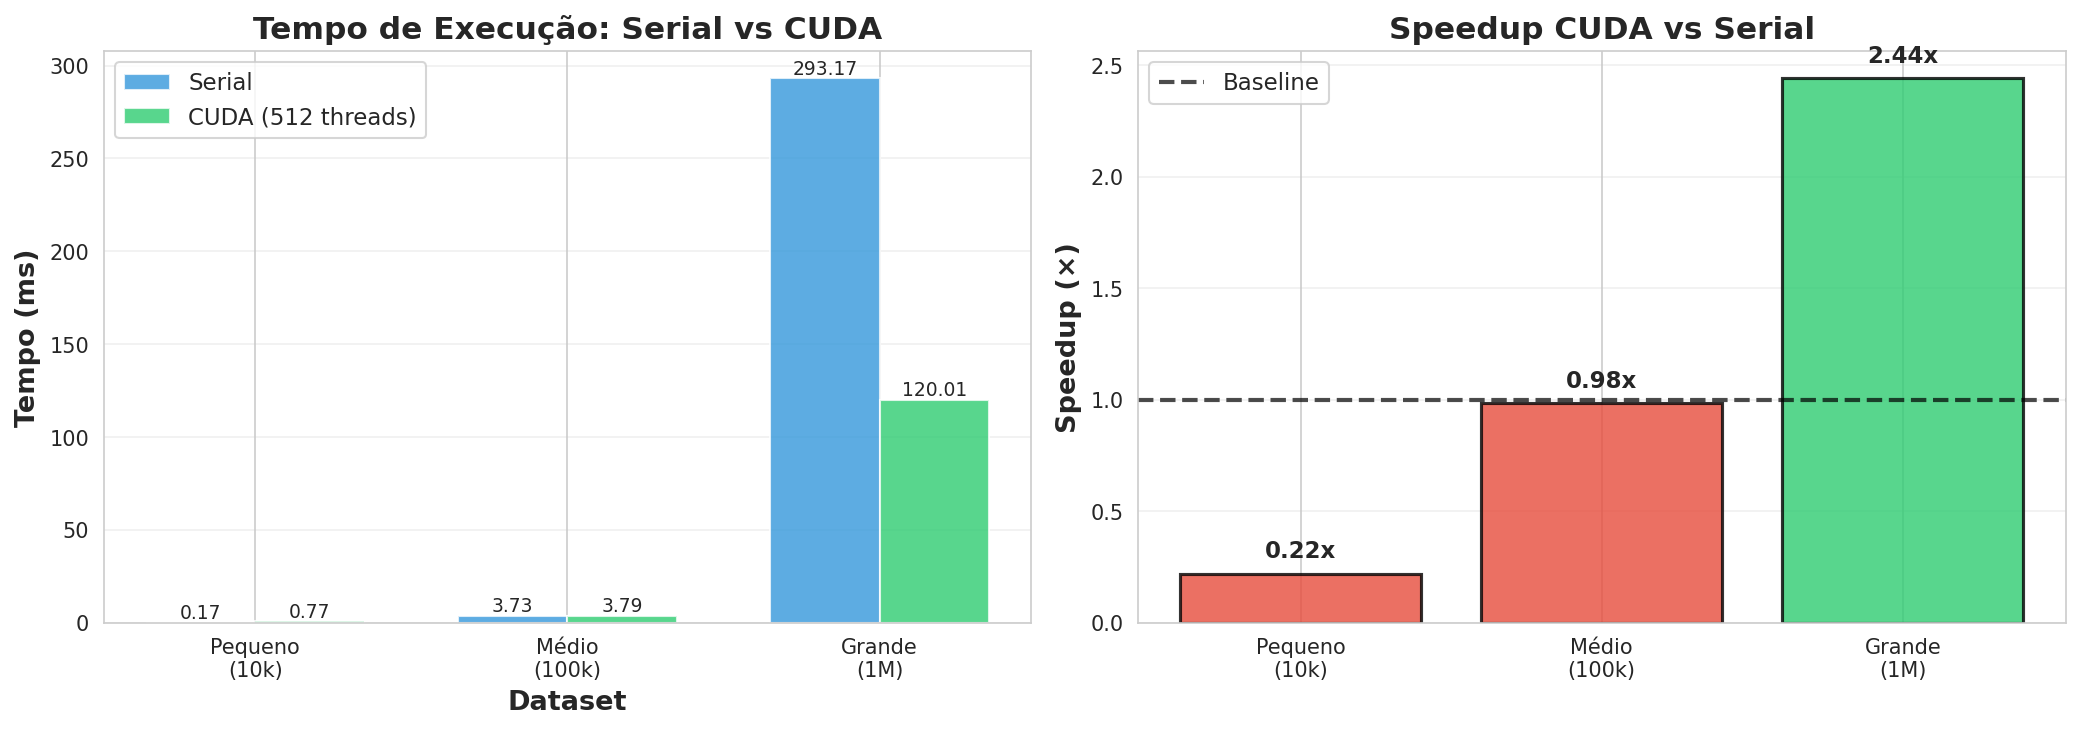

In [31]:
#GRÁFICO 1 - DESEMPENHO GERAL
import matplotlib.pyplot as plt
import numpy as np

# Dados
datasets_names = ['Pequeno\n(10k)', 'Médio\n(100k)', 'Grande\n(1M)']
serial_times = [0.17, 3.73, 293.17]
cuda_times = [0.77, 3.79, 120.01]
speedups = [s/c for s, c in zip(serial_times, cuda_times)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Tempo
x = np.arange(len(datasets_names))
width = 0.35

bars1 = ax1.bar(x - width/2, serial_times, width, label='Serial', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, cuda_times, width, label='CUDA (512 threads)', color='#2ecc71', alpha=0.8)

ax1.set_ylabel('Tempo (ms)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Dataset', fontsize=13, fontweight='bold')
ax1.set_title('Tempo de Execução: Serial vs CUDA', fontsize=15, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(datasets_names)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Gráfico 2: Speedup
colors = ['#e74c3c' if sp < 1 else '#27ae60' if sp < 2 else '#2ecc71' for sp in speedups]
bars = ax2.bar(datasets_names, speedups, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axhline(y=1, color='black', linestyle='--', linewidth=2, label='Baseline', alpha=0.7)

ax2.set_ylabel('Speedup (×)', fontsize=13, fontweight='bold')
ax2.set_title('Speedup CUDA vs Serial', fontsize=15, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)

for bar, sp in zip(bars, speedups):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{sp:.2f}x', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/projeto-kmeans-cuda/resultados/grafico_desempenho.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico 1 salvo: grafico_desempenho.png")
plt.show()

✓ Gráfico 2 salvo: grafico_threads.png


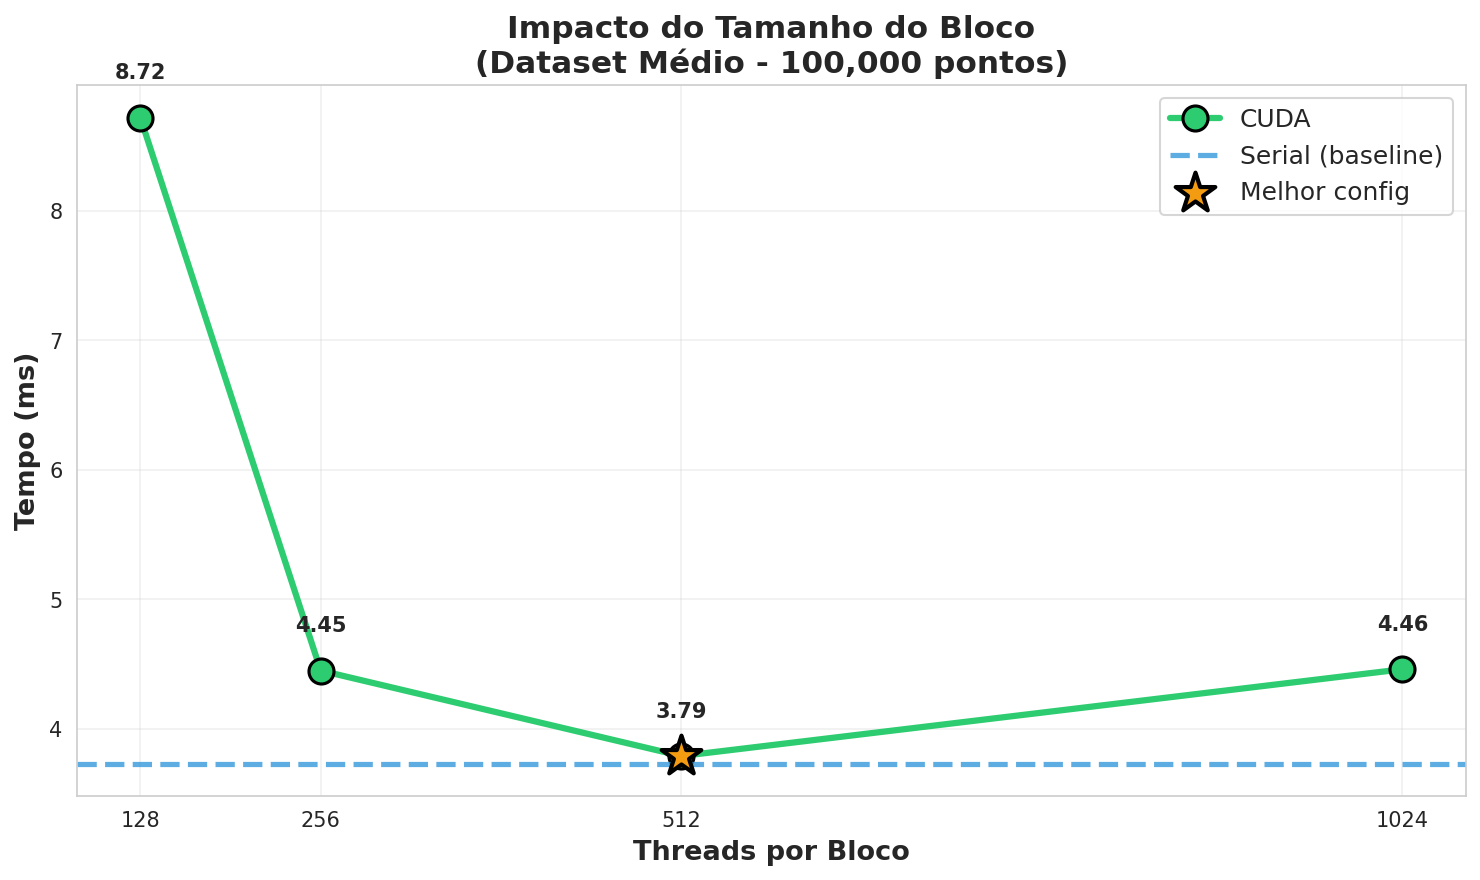

In [32]:
#GRÁFICO 2 - IMPACTO DE THREADS
import matplotlib.pyplot as plt

threads = [128, 256, 512, 1024]
tempos_threads = [8.72, 4.45, 3.79, 4.46]
serial_medio = 3.73

fig, ax = plt.subplots(figsize=(10, 6))

line = ax.plot(threads, tempos_threads, marker='o', linewidth=3, markersize=12,
               color='#2ecc71', label='CUDA', markeredgecolor='black', markeredgewidth=1.5)
ax.axhline(y=serial_medio, color='#3498db', linestyle='--', linewidth=2.5,
           label='Serial (baseline)', alpha=0.8)

best_idx = tempos_threads.index(min(tempos_threads))
ax.scatter(threads[best_idx], tempos_threads[best_idx], s=400,
           color='#f39c12', marker='*', zorder=5, edgecolor='black',
           linewidth=2, label='Melhor config')

ax.set_xlabel('Threads por Bloco', fontsize=13, fontweight='bold')
ax.set_ylabel('Tempo (ms)', fontsize=13, fontweight='bold')
ax.set_title('Impacto do Tamanho do Bloco\n(Dataset Médio - 100,000 pontos)',
             fontsize=15, fontweight='bold')
ax.set_xticks(threads)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

for t, tempo in zip(threads, tempos_threads):
    ax.text(t, tempo + 0.3, f'{tempo:.2f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/projeto-kmeans-cuda/resultados/grafico_threads.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico 2 salvo: grafico_threads.png")
plt.show()

✓ Gráfico 3 salvo: grafico_escalabilidade.png


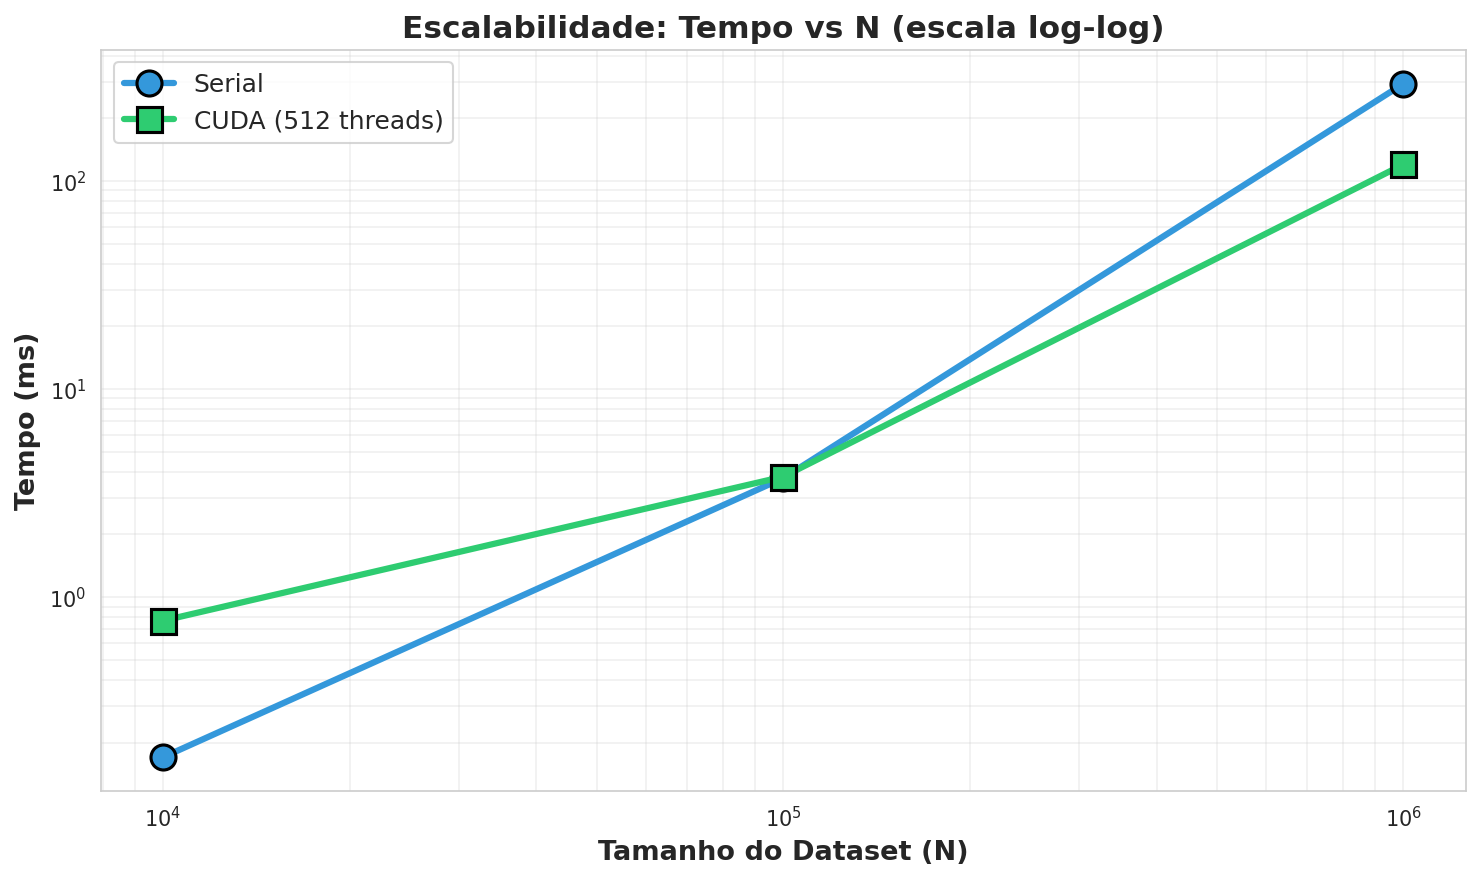

In [33]:
#GRÁFICO 3 - ESCALABILIDADE (LOG-LOG)
import matplotlib.pyplot as plt
import numpy as np

n_values = [10000, 100000, 1000000]
serial_times = [0.17, 3.73, 293.17]
cuda_times = [0.77, 3.79, 120.01]

fig, ax = plt.subplots(figsize=(10, 6))

ax.loglog(n_values, serial_times, marker='o', linewidth=3, markersize=12,
          label='Serial', color='#3498db', markeredgecolor='black', markeredgewidth=1.5)
ax.loglog(n_values, cuda_times, marker='s', linewidth=3, markersize=12,
          label='CUDA (512 threads)', color='#2ecc71', markeredgecolor='black', markeredgewidth=1.5)

ax.set_xlabel('Tamanho do Dataset (N)', fontsize=13, fontweight='bold')
ax.set_ylabel('Tempo (ms)', fontsize=13, fontweight='bold')
ax.set_title('Escalabilidade: Tempo vs N (escala log-log)',
             fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, which="both", alpha=0.3)

plt.tight_layout()
plt.savefig('/content/projeto-kmeans-cuda/resultados/grafico_escalabilidade.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico 3 salvo: grafico_escalabilidade.png")
plt.show()


✓ Gráfico 4 salvo: grafico_amdahl.png

Análise de Amdahl:
  Speedup teórico máx: 2.50×
  Speedup real: 2.44×
  Eficiência: 97.7%


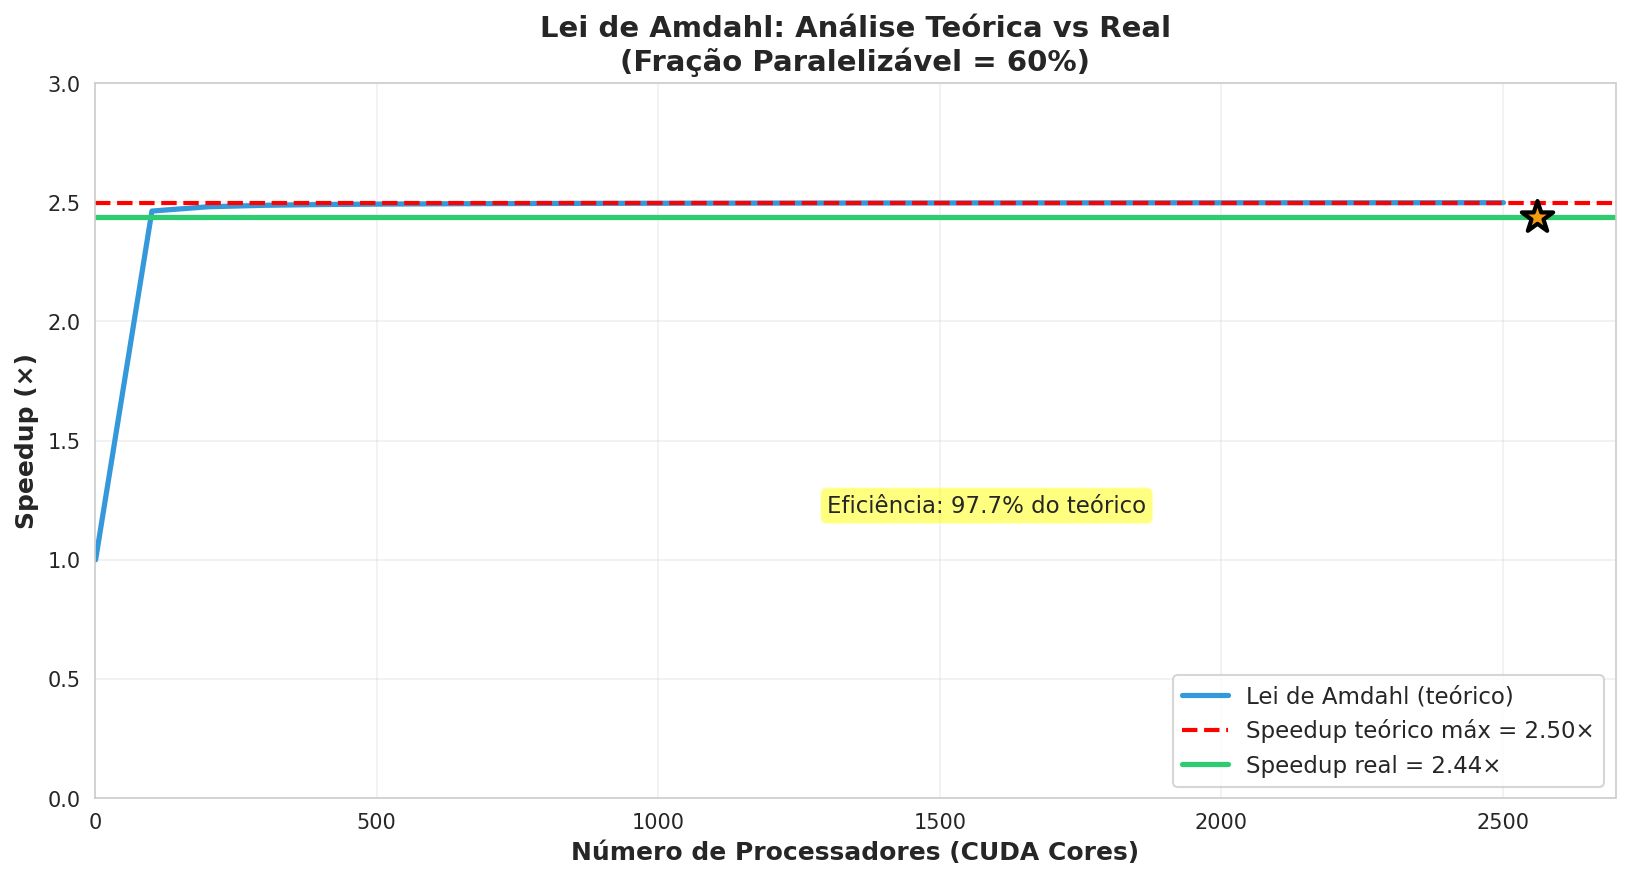

In [34]:
#ANÁLISE DE LEI DE AMDAHL
import matplotlib.pyplot as plt
import numpy as np

def amdahl_speedup(p, s):
    """Lei de Amdahl: p fração paralelizável, s processadores"""
    return 1 / ((1 - p) + (p / s))

p_empirica = 0.6  # 60% paralelizável
cuda_cores = 2560

speedups_teoricos = [amdahl_speedup(p_empirica, s) for s in range(1, cuda_cores+1, 100)]
processadores = list(range(1, cuda_cores+1, 100))

speedup_real = 2.44
speedup_teorico_max = amdahl_speedup(p_empirica, cuda_cores)

plt.figure(figsize=(11, 6))
plt.plot(processadores, speedups_teoricos, linewidth=2.5, label='Lei de Amdahl (teórico)', color='#3498db')
plt.axhline(y=speedup_teorico_max, color='red', linestyle='--', linewidth=2,
            label=f'Speedup teórico máx = {speedup_teorico_max:.2f}×')
plt.axhline(y=speedup_real, color='#2ecc71', linestyle='-', linewidth=2.5,
            label=f'Speedup real = {speedup_real:.2f}×')
plt.scatter([cuda_cores], [speedup_real], s=250, color='#f39c12',
           marker='*', zorder=5, edgecolor='black', linewidth=2)

plt.xlabel('Número de Processadores (CUDA Cores)', fontsize=12, fontweight='bold')
plt.ylabel('Speedup (×)', fontsize=12, fontweight='bold')
plt.title('Lei de Amdahl: Análise Teórica vs Real\n(Fração Paralelizável = 60%)',
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(alpha=0.3)
plt.xlim(0, 2700)
plt.ylim(0, 3)

eficiencia = (speedup_real / speedup_teorico_max) * 100
plt.text(1300, 1.2, f'Eficiência: {eficiencia:.1f}% do teórico',
        fontsize=11, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.savefig('/content/projeto-kmeans-cuda/resultados/grafico_amdahl.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico 4 salvo: grafico_amdahl.png")
print(f"\nAnálise de Amdahl:")
print(f"  Speedup teórico máx: {speedup_teorico_max:.2f}×")
print(f"  Speedup real: {speedup_real:.2f}×")
print(f"  Eficiência: {eficiencia:.1f}%")
plt.show()


In [35]:
#SALVAR TODOS OS ARQUIVOS
import os

os.chdir('/content/projeto-kmeans-cuda')

print("\n📁 ARQUIVOS GERADOS:\n")

arquivos = [
    ('resultados/tabela_desempenho.csv', 'Tabela de desempenho completa'),
    ('resultados/grafico_desempenho.png', 'Gráfico: Tempo + Speedup'),
    ('resultados/grafico_threads.png', 'Gráfico: Impacto de threads'),
    ('resultados/grafico_escalabilidade.png', 'Gráfico: Escalabilidade log-log'),
    ('resultados/grafico_amdahl.png', 'Gráfico: Lei de Amdahl'),
]

for arq, desc in arquivos:
    if os.path.exists(arq):
        size = os.path.getsize(arq) / 1024
        print(f"✓ {arq:<40} ({size:>6.1f} KB) - {desc}")

print("\n💾 DOWNLOAD DOS ARQUIVOS:")
print("   Files → Download all files → projeto-kmeans-cuda.zip")


📁 ARQUIVOS GERADOS:

✓ resultados/tabela_desempenho.csv         (   0.5 KB) - Tabela de desempenho completa
✓ resultados/grafico_desempenho.png        ( 184.2 KB) - Gráfico: Tempo + Speedup
✓ resultados/grafico_threads.png           ( 182.6 KB) - Gráfico: Impacto de threads
✓ resultados/grafico_escalabilidade.png    ( 189.2 KB) - Gráfico: Escalabilidade log-log
✓ resultados/grafico_amdahl.png            ( 184.0 KB) - Gráfico: Lei de Amdahl

💾 DOWNLOAD DOS ARQUIVOS:
   Files → Download all files → projeto-kmeans-cuda.zip
